In [3]:
import pandas as pd
import requests
import pandas_ta as ta
import matplotlib.pyplot as plt
from termcolor import colored as cl
import math 

plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

# Getting historical data of AAPL Stock 

In [7]:
import requests
import pandas as pd

def get_historical_data(symbol, start_date, interval):
    url = "https://api.benzinga.com/api/v2/bars"
    querystring = {"token":"6885ad9469db44c18b1fc8546bbadc3c","symbols":f"{symbol}","from":f"{start_date}","interval":f"{interval}"}

    response = requests.get(url, params=querystring)
    
    if response.status_code != 200:
        print(f"Failed to retrieve data for {symbol}. Status code: {response.status_code}")
        return None
    
    hist_json = response.json()
    
    if not hist_json or not hist_json[0]['candles']:
        print("Empty response or no candles data found.")
        return None
    
    df = pd.DataFrame(hist_json[0]['candles'])
    
    return df

aapl = get_historical_data('AAPL', '1993-01-01', '1W')
if aapl is not None:
    print(aapl.tail())


               time     open    high     low   close     volume  \
1620  1705881600000  192.300  196.38  191.94  192.42  255536900   
1621  1706486400000  192.010  192.20  179.25  185.85  325909880   
1622  1707091200000  188.150  191.05  185.84  188.85  252715800   
1623  1707696000000  188.415  188.67  181.35  182.31  268128940   
1624  1708300800000  181.790  185.04  180.00  182.52  192607110   

                           dateTime  
1620  2024-01-22T15:00:00.000-05:00  
1621  2024-01-29T15:00:00.000-05:00  
1622  2024-02-05T15:00:00.000-05:00  
1623  2024-02-12T15:00:00.000-05:00  
1624  2024-02-19T15:00:00.000-05:00  


# CALCULATING DONCHIAN CHANNEL

In [8]:
aapl[['dcl', 'dcm', 'dcu']] = aapl.ta.donchian(lower_length = 40, upper_length = 50)
aapl = aapl.dropna().drop('time', axis = 1).rename(columns = {'dateTime':'date'})
aapl = aapl.set_index('date')
aapl.index = pd.to_datetime(aapl.index)

aapl.tail()

/tmp/ipykernel_4912/2983612939.py:6: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  aapl.index = pd.to_datetime(aapl.index)


,open,high,low,close,volume,dcl,dcm,dcu
date,,,,,,,,
2024-01-22 15:00:00-05:00,192.300,196.38,191.94,192.42,255536900,162.80,181.210,199.62
2024-01-29 15:00:00-05:00,192.010,192.20,179.25,185.85,325909880,164.31,181.965,199.62
2024-02-05 15:00:00-05:00,188.150,191.05,185.84,188.85,252715800,165.67,182.645,199.62
2024-02-12 15:00:00-05:00,188.415,188.67,181.35,182.31,268128940,165.67,182.645,199.62
2024-02-19 15:00:00-05:00,181.790,185.04,180.00,182.52,192607110,165.67,182.645,199.62


# PLOTTING DONCHIAN CHANNEL

Text(0, 0.5, 'Close')

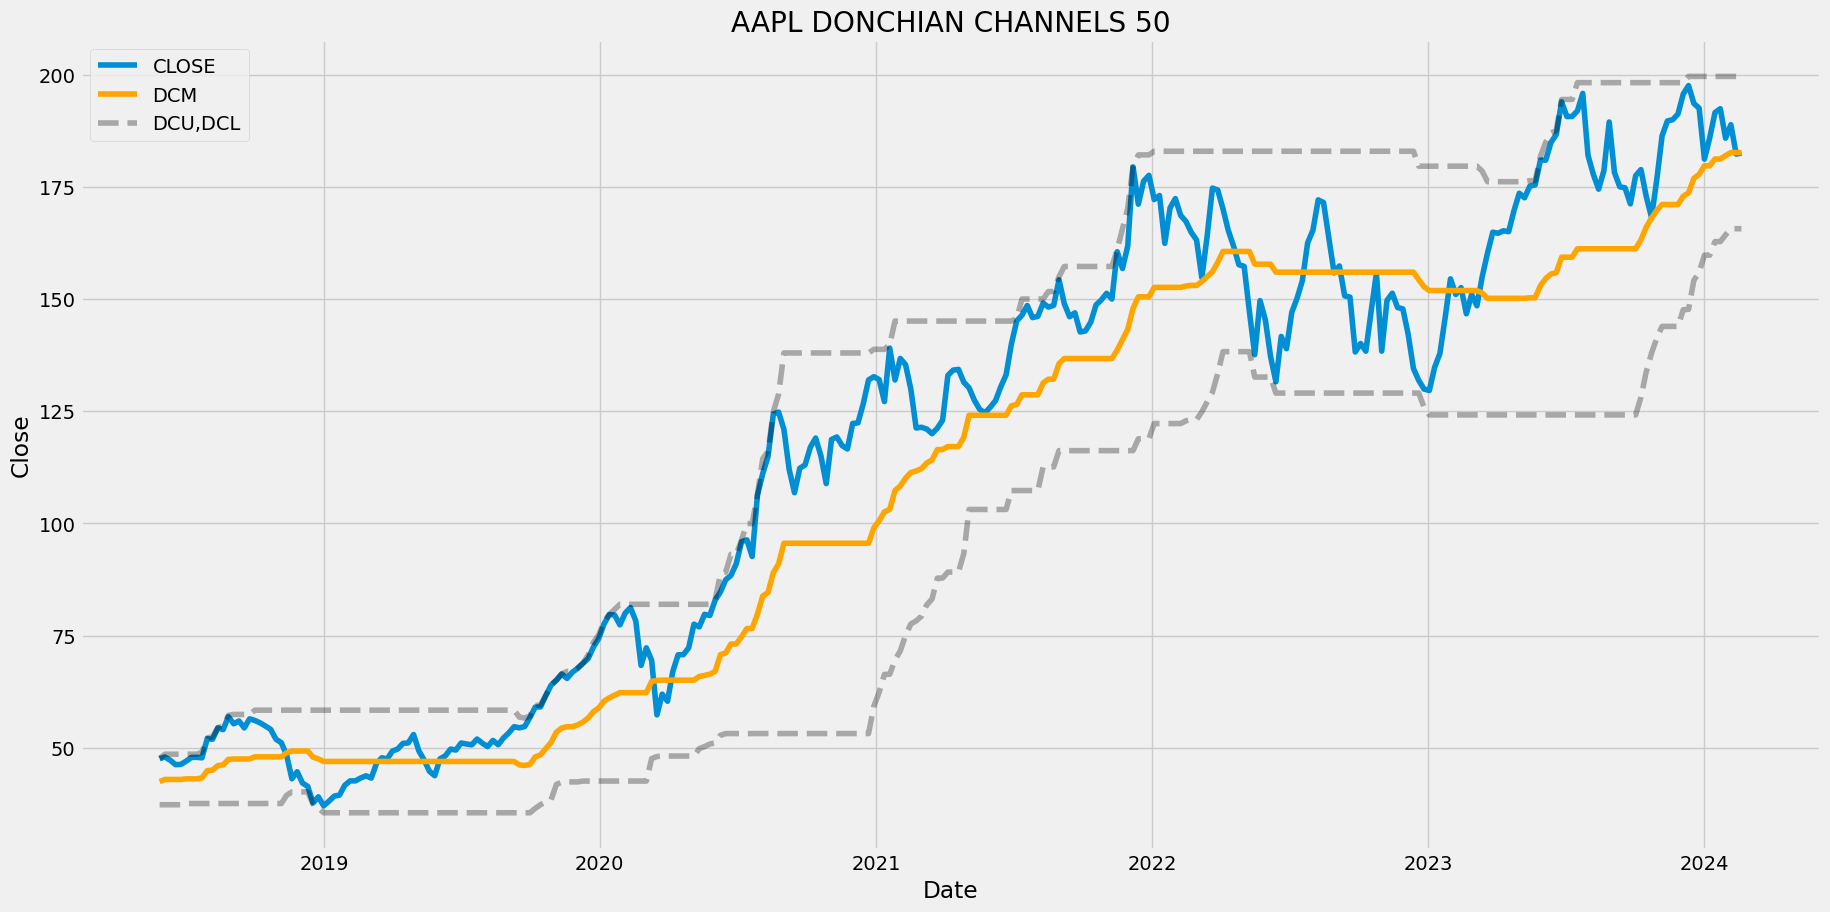

In [9]:
plt.plot(aapl[-300:].close, label = 'CLOSE')
plt.plot(aapl[-300:].dcl, color = 'black', linestyle = '--', alpha = 0.3)
plt.plot(aapl[-300:].dcm, color = 'orange', label = 'DCM')
plt.plot(aapl[-300:].dcu, color = 'black', linestyle = '--', alpha = 0.3, label = 'DCU,DCL')
plt.legend()
plt.title('AAPL DONCHIAN CHANNELS 50')
plt.xlabel('Date')
plt.ylabel('Close')

In [21]:
import math
from termcolor import colored as cl
import time

def implement_strategy(aapl, investment):
    start_time = time.time()

    in_position = False
    equity = investment
    buy_actions = []
    sell_actions = []

    high_prices = aapl['high']
    low_prices = aapl['low']
    close_prices = aapl['close']
    dcu_values = aapl['dcu']
    dcl_values = aapl['dcl']

    for i in range(3, len(aapl)):
        if high_prices[i] == dcu_values[i] and not in_position:
            no_of_shares = math.floor(equity / close_prices[i])
            equity -= (no_of_shares * close_prices[i])
            in_position = True
            buy_actions.append((no_of_shares, close_prices[i], aapl.index[i]))
        elif low_prices[i] == dcl_values[i] and in_position:
            equity += (no_of_shares * close_prices[i])
            in_position = False
            sell_actions.append((no_of_shares, close_prices[i], aapl.index[i]))

    if in_position:
        equity += (no_of_shares * close_prices[-1])
        sell_actions.append((no_of_shares, close_prices[-1], aapl.index[-1]))

    for action in buy_actions:
        print(cl(f'BUY: {action[0]} Shares are bought at ${action[1]} on {str(action[2])[:10]}', color='green', attrs=['bold']))
    for action in sell_actions:
        print(cl(f'SELL: {action[0]} Shares are sold at ${action[1]} on {str(action[2])[:10]}', color='red', attrs=['bold']))

    earning = round(equity - investment, 2)
    roi = round(earning / investment * 100, 2)
    print(cl(f'EARNING: ${earning} ; ROI: {roi}%', attrs=['bold']))

    end_time = time.time()
    execution_time = round(end_time - start_time, 4)
    print(f"Execution time: {execution_time} seconds")

# Assuming 'dcu' and 'dcl' columns are already in DataFrame
implement_strategy(aapl, 100000)



BUY: 272340 Shares are bought at $0.3671875 on 1994-10-10
BUY: 365659 Shares are bought at $0.2393975 on 1997-08-04
BUY: 212688 Shares are bought at $0.2494422 on 1998-04-13
BUY: 219244 Shares are bought at $0.4460715 on 2002-04-15
BUY: 170827 Shares are bought at $0.3428571 on 2003-06-16
BUY: 97991 Shares are bought at $6.043571 on 2009-08-17
BUY: 89836 Shares are bought at $19.859643 on 2013-11-25
BUY: 85496 Shares are bought at $29.76 on 2017-01-09
BUY: 56768 Shares are bought at $56.7525 on 2019-09-30
BUY: 44591 Shares are bought at $175.16 on 2023-05-15
SELL: 272340 Shares are sold at $0.3214286 on 1995-10-09
SELL: 365659 Shares are sold at $0.14508928 on 1997-12-29
SELL: 212688 Shares are sold at $0.4598215 on 2000-09-25
SELL: 219244 Shares are sold at $0.2671429 on 2002-07-15
SELL: 170827 Shares are sold at $3.466786 on 2008-09-29
SELL: 97991 Shares are sold at $18.206929 on 2012-12-10
SELL: 89836 Shares are sold at $28.3225 on 2015-08-24
SELL: 85496 Shares are sold at $37.6825 

/tmp/ipykernel_4912/2669393747.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if high_prices[i] == dcu_values[i] and not in_position:
/tmp/ipykernel_4912/2669393747.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif low_prices[i] == dcl_values[i] and in_position:
/tmp/ipykernel_4912/2669393747.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  no_of_shares = math.floor(equity / close_prices[i])
/tmp/ipykernel_4912/266

In [24]:
spy = get_historical_data('SPY', '1993-01-01', '1W')
spy_ret = round(((spy.close.iloc[-1] - spy.close.iloc[0])/spy.close.iloc[0])*100)

print(cl('SPY ETF buy/hold return:', attrs = ['bold']), f'{spy_ret}%')

SPY ETF buy/hold return: 1056%
